# 03_preprocessing_and_modelling_realized_volatility_capstone_project

## Key Objectives 

1) Develop features based on stock data in the book and trade files.

2) Create a class for pre-processing raw data across all stocks into a single features dataframe.

3) Train a model on the features dataframe, using a part of the data as the validation set.

4) Tune the hyperparameters of the model to improve its performance on the validation set.

5) Finally, use the tuned model to make predictions on test set and evaluate its performance. 



In [7]:
import pandas as pd
import numpy as np
import glob
from sb_utils import save_file
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import kstest, norm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans

import time


np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install lightgbm

import tensorflow as tf
from tensorflow.keras import Model, Input
import keras
from keras.layers import Dense, Embedding, Concatenate, Flatten
from keras.models import Sequential
from keras.layers import LeakyReLU
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
import xgboost as xgb
import lightgbm as lgb


## 1.0 Key Functions

Define important functions required for feature building and preprocessing.

### 1.1 General Functions

In [270]:

def log_return(list_stock_prices):
    # calculate the log return of a price series
    
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    # calculate the realized volatility using a series of log return for a stock
    
    return np.sqrt(np.sum(series_log_return**2))

def high_low_index(price_series):
    # Calculate the value of highest price divided by lowest price for a time bucket
    
    return ((np.max(price_series) / np.min(price_series)))

def close_open_index(price_series):
    # Calculate the value of closing price divided by opening price for a time bucket
    
    return ((price_series.values[-1] / price_series.values[0]))

def rmspe(y_true, y_pred):
    # Calculate the root mean squared percentage error. This is an evaluation criteria defined by Optiver.
    
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# custom loss function in tensorflow
def keras_rmspe(y_true, y_pred):
    
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

def get_model_lrelu(no_of_features, neurons, alphas=[0.3,0.3]):
    # function to generate sequential keras model with leakyrelu activation function
    
    new_model = Sequential()
    new_model.add(Dense(neurons[0], activation=LeakyReLU(alpha=alphas[0]), input_shape=(no_of_features,)))
    
    for idx, units in enumerate(neurons):
        if idx > 0:
            new_model.add(Dense(units, activation=LeakyReLU(alpha=alphas[idx])))
    
    new_model.add(Dense(1))
    
    return new_model
    


### 1.2 Functions to create book features

In [42]:

def book_params(df_book):
    ## calculate key parameters for book
  
    df_book['wap_1'] = (df_book.bid_price1*df_book.ask_size1 + df_book.ask_price1*df_book.bid_size1) \
                        /(df_book.ask_size1 + df_book.bid_size1)
    df_book['wap_2'] = (df_book.bid_price2*df_book.ask_size2 + df_book.ask_price2*df_book.bid_size2) \
                        /(df_book.ask_size2 + df_book.bid_size2)
    
    df_book['wap_diff'] = df_book['wap_1'] - df_book['wap_2']
    df_book['wap_diff_absolute'] = np.abs(df_book['wap_diff'])
    
    df_book['log_return_1'] = df_book.groupby(['time_id'])['wap_1'].apply(log_return)
    df_book['log_return_2'] = df_book.groupby(['time_id'])['wap_2'].apply(log_return)
    
    df_book['spread_1'] = (df_book.ask_price1 / df_book.bid_price1 ) - 1.0
    df_book['spread_2'] = (df_book.ask_price2 / df_book.bid_price2 ) - 1.0
        
    df_book['speed_wap1'] = df_book.groupby('time_id')['wap_1'].diff()
    df_book['speed_wap1'] = df_book['speed_wap1'].fillna(0.0)
    df_book['acceleration_wap1'] = np.abs(df_book.groupby('time_id')['speed_wap1'].diff())
    df_book['speed_wap1'] = np.abs(df_book['speed_wap1'])
    df_book['acceleration_wap1'] = df_book['acceleration_wap1'].fillna(0.0)
    df_book['momentum_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            df_book['speed_wap1']
    df_book['force_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            df_book['acceleration_wap1']
        
    return df_book

def features_from_book(df_book, time_splits = 1):
    ## build book features using book parameters
    
    ## wap features
    book_features = pd.DataFrame(df_book.groupby(['stock_id','time_id'])['wap_1'].agg([high_low_index])).reset_index()
    book_features = book_features.rename(columns = {'high_low_index': 'wap1_hl_ratio'})
    wap2_features = pd.DataFrame(df_book.groupby(['time_id'])['wap_2'].agg([high_low_index])).reset_index()
    wap2_features = wap2_features.rename(columns = {'high_low_index': 'wap2_hl_ratio'})  
    wap_diff_features = pd.DataFrame(df_book.groupby(['time_id'])['wap_diff'].agg([np.std])).reset_index()
    wap_diff_features = wap_diff_features.rename(columns = {'std': 'wap_diff_std'})
    book_features = book_features.merge(wap2_features, on='time_id', how='left').merge(wap_diff_features, on='time_id', how='left')
    
    ## spread features
    spread1_features = pd.DataFrame(df_book.groupby(['time_id'])['spread_1'].agg([np.sum, np.std])).reset_index()
    spread1_features = spread1_features.rename(columns = {'sum': 'spread_1_sum', 'std': 'spread_1_std'})
    spread2_features = pd.DataFrame(df_book.groupby(['time_id'])['spread_2'].agg([np.sum, np.std])).reset_index()
    spread2_features = spread2_features.rename(columns = {'sum': 'spread_2_sum', 'std': 'spread_2_std'})
    book_features = book_features.merge(spread1_features, on='time_id', how='left').merge(spread2_features, on='time_id', how='left')
    
    ## speed & acceleration features
    speed_features = pd.DataFrame(df_book.groupby(['time_id'])['speed_wap1'].agg([np.sum,np.std])).reset_index()
    speed_features = speed_features.rename(columns = {'sum': 'speed_wap1_sum', 'std': 'speed_wap1_std'})
    acceleration_features = pd.DataFrame(df_book.groupby(['time_id'])['acceleration_wap1'].agg([np.sum, np.std])).reset_index()
    acceleration_features = acceleration_features.rename(columns = {'sum': 'acceleration_wap1_sum', \
                                                        'std': 'acceleration_wap1_std'})
    book_features = book_features.merge(speed_features, on='time_id', how='left').merge(acceleration_features, \
                                                                                        on='time_id', how='left')
    ## momentum & force features
    momentum_features = pd.DataFrame(df_book.groupby(['time_id'])['momentum_book'].agg([np.sum,np.std])).reset_index()
    momentum_features = momentum_features.rename(columns = {'sum': 'momentum_book_sum', 'std': 'momentum_book_std'})
    force_features = pd.DataFrame(df_book.groupby(['time_id'])['force_book'].agg([np.sum, np.std])).reset_index()
    force_features = force_features.rename(columns = {'sum': 'force_book_sum', 'std': 'force_book_std'})
    book_features = book_features.merge(momentum_features, on='time_id', how='left').merge(force_features, \
                                                                                        on='time_id', how='left')
    ## volatility features
    book_vol_1 = pd.DataFrame(df_book.groupby('time_id')['log_return_1'].agg(realized_volatility)).reset_index()
    book_vol_1 = book_vol_1.rename(columns = {'log_return_1': "realized_vol_wap1"})
    book_vol_2 = pd.DataFrame(df_book.groupby('time_id')['log_return_2'].agg(realized_volatility)).reset_index()
    book_vol_2 = book_vol_2.rename(columns = {'log_return_2': "realized_vol_wap2"})
    book_features = book_features.merge(book_vol_1, on='time_id', how='left').merge(book_vol_2, on='time_id', how='left')
    
    ## book features for time_splits within the 10-minutes of available data
    if time_splits != 1:
        second_limits = [(600 * x / time_splits) - 1 for x in np.arange(1, time_splits+1)]
        for idx, limit in enumerate(second_limits):
            if idx == 0:
                df_temp = df_book[df_book["seconds_in_bucket"] <= limit ]
            else:
                df_temp = df_book[(df_book["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_book["seconds_in_bucket"] <= limit)]
            
            acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_wap1'].agg([np.sum, np.std])).reset_index()
            acc_features = acc_features.rename(columns = {'sum': f'acceleration_wap1_sum_band{idx+1}', \
                                                        'std': f'acceleration_wap1_std_band{idx+1}'})
            vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return_1'].agg(realized_volatility)).reset_index()
            vol_features = vol_features.rename(columns = {'log_return_1': f"realized_vol_wap1_band{idx+1}"})
            book_features = book_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
            
        book_features['rv_(mean-band1)'] = (book_features['realized_vol_wap1'] /(2.0**0.5)) - book_features['realized_vol_wap1_band1']
        book_features['acc_sum_(mean-band1)'] = (book_features['acceleration_wap1_sum']/(2.0)) - book_features['acceleration_wap1_sum_band1']
        book_features['acc_std_(mean-band1)'] = (book_features['acceleration_wap1_std']/(2.0**0.5)) - book_features['acceleration_wap1_std_band1']
        book_features['rv_(mean-band2)'] = (book_features['realized_vol_wap1'] /(2.0**0.5)) - book_features['realized_vol_wap1_band2']
        book_features['acc_sum_(mean-band2)'] = (book_features['acceleration_wap1_sum']/(2.0)) - book_features['acceleration_wap1_sum_band2']
        book_features['acc_std_(mean-band2)'] = (book_features['acceleration_wap1_std']/(2.0**0.5)) - book_features['acceleration_wap1_std_band2']

    return book_features



### 1.3 Functions to create trade features

In [43]:

def join_wap_prices_from_book(df_trade, df_book):
    #function to import wap prices into trade file to enable calculation of trade price premiums
    
    time_ids = list(df_trade.time_id.unique())

    trade_new = pd.DataFrame()
    for idx, time_id in enumerate(time_ids):
        trade_temp = df_trade[df_trade.time_id == time_id]
        book_temp = df_book[df_book.time_id == time_id]
        book_temp_0sec = book_temp[book_temp.seconds_in_bucket ==0]
        book_temp['seconds_in_bucket'] = book_temp['seconds_in_bucket'] + 1
        book_temp = pd.concat([book_temp, book_temp_0sec], ignore_index=True)
        trade_temp = trade_temp.merge(book_temp[['seconds_in_bucket', 'wap_1', 'wap_2']], on = 'seconds_in_bucket', how='left')
        trade_temp = trade_temp.rename(columns = {'wap_1': 'wap_1_(s-1)', 'wap_2': 'wap_2_(s-1)'})
        trade_new = pd.concat([trade_new, trade_temp], ignore_index=True)

    return trade_new

def trade_params(df_trade):
    ## calculate key parameters for trade file
    df_trade['price_premium_1'] = np.abs(df_trade['price'] -  df_trade['wap_1_(s-1)'])
    df_trade['price_premium_2'] = np.abs(df_trade['price'] -  df_trade['wap_2_(s-1)'])
    df_trade['value_premium_1'] = df_trade['size'] * df_trade['price_premium_1'] 
    df_trade['value_premium_2'] = df_trade['size'] * df_trade['price_premium_2']
    df_trade['log_return'] = df_trade.groupby(['time_id'])['price'].apply(log_return)
    df_trade['turnover'] = df_trade['price']*df_trade['size']
    
    df_trade['speed'] = df_trade.groupby(['time_id'])['price'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff()
    df_trade['speed'] = df_trade['speed'].fillna(0.0)
    df_trade['acceleration_trade_price'] = np.abs(df_trade.groupby(['time_id'])['speed'].diff() \
                                                  / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff())
    df_trade['speed_trade_price'] = np.abs(df_trade['speed'])
    df_trade['acceleration_trade_price'] = df_trade['acceleration_trade_price'].fillna(0.0)
    df_trade.drop(columns=['speed'], inplace=True)
    df_trade['momentum_trade'] = df_trade['speed_trade_price'] * df_trade['size']
    df_trade['force_trade'] = df_trade['acceleration_trade_price'] * df_trade['size']
    
    df_trade = df_trade[~df_trade['log_return'].isnull()]

    return df_trade

def features_from_trade(df_trade, time_splits=1):
    ## build trade features using trade parameters
    
    # price premium features
    trade_features = pd.DataFrame(df_trade.groupby('time_id')['price_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
    trade_features = trade_features.rename(columns = {'sum': 'price_premium_1_sum', 'mean': 'price_premium_1_mean',\
                                                      'std': 'price_premium_1_std'})
    prem2_features = pd.DataFrame(df_trade.groupby('time_id')['price_premium_2'].agg([np.sum, np.mean, np.std])).reset_index()
    prem2_features = prem2_features.rename(columns = {'sum': 'price_premium_2_sum', 'mean': 'price_premium_2_mean',\
                                                      'std': 'price_premium_2_std'})
    trade_features = trade_features.merge(prem2_features, on='time_id', how='left')
    
    # value premium features
    val1_features = pd.DataFrame(df_trade.groupby('time_id')['value_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
    val1_features = val1_features.rename(columns = {'sum': 'value_premium_1_sum', 'mean': 'value_premium_1_mean',\
                                                    'std': 'value_premium_1_std'})
    val2_features = pd.DataFrame(df_trade.groupby('time_id')['value_premium_2'].agg([np.sum, np.mean, np.std])).reset_index()
    val2_features = val2_features.rename(columns = {'sum': 'value_premium_2_sum', 'mean': 'value_premium_2_mean',\
                                                    'std': 'value_premium_2_std'})
    trade_features = trade_features.merge(val1_features, on='time_id', how='left').merge(\
                                                                                val2_features, on='time_id', how='left')
    
    # speed & acceleration features
    speed_features = pd.DataFrame(df_trade.groupby(['time_id'])['speed_trade_price'].agg([np.sum,np.mean, np.std])).reset_index()
    speed_features = speed_features.rename(columns = {'sum': 'speed_trade_price_sum', 'mean': 'speed_trade_price_mean',\
                                                      'std': 'speed_trade_price_std'})
    acceleration_features = pd.DataFrame(df_trade.groupby(['time_id'])['acceleration_trade_price'].agg(\
                                                                                        [np.sum, np.mean, np.std])).reset_index()
    acceleration_features = acceleration_features.rename(columns = {'sum': 'acceleration_trade_price_sum', \
                                            'mean': 'acceleration_trade_price_mean', 'std': 'acceleration_trade_price_std'})
    trade_features = trade_features.merge(speed_features, on='time_id', how='left').merge(acceleration_features, \
                                                                                        on='time_id', how='left')
    
    # momentum & force features
    momentum_features = pd.DataFrame(df_trade.groupby(['time_id'])['momentum_trade'].agg([np.sum,np.mean, np.std])).reset_index()
    momentum_features = momentum_features.rename(columns = {'sum': 'momentum_trade_sum', 'mean': 'momentum_trade_mean',\
                                                            'std': 'momentum_trade_std'})
    force_features = pd.DataFrame(df_trade.groupby(['time_id'])['force_trade'].agg([np.sum, np.mean, np.std])).reset_index()
    force_features = force_features.rename(columns = {'sum': 'force_trade_sum', 'mean': 'force_trade_mean', \
                                                      'std': 'force_trade_std'})
    trade_features = trade_features.merge(momentum_features, on='time_id', how='left').merge(force_features, \
                                                                                        on='time_id', how='left')
    # turnover & order_size features
    other_features = pd.DataFrame(\
                    df_trade.groupby('time_id')[['turnover','size','order_count']].sum()).reset_index()
    trade_features = trade_features.merge(other_features, on='time_id', how='left')
    
    # trade price features
    price_moves_trade = pd.DataFrame(df_trade.groupby('time_id')['price'].agg([high_low_index])).reset_index()
    price_moves_trade = price_moves_trade.rename(columns = {'high_low_index': 'hl_ratio_trade_price'})
    trade_features = trade_features.merge(price_moves_trade, on='time_id', how='left')
    
    # seconds active(no. of seconds trades took place) features
    seconds_active = pd.DataFrame(df_trade.groupby('time_id')['seconds_in_bucket'].count()).reset_index()
    seconds_active = seconds_active.rename(columns = {'seconds_in_bucket': 'seconds_active'})
    trade_features = trade_features.merge(seconds_active, on='time_id', how='left')
    
    #trade price volatility features
    trade_vol = pd.DataFrame(df_trade.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    trade_vol = trade_vol.rename(columns = {'log_return': "realized_vol_trade_price"})
    trade_features = trade_features.merge(trade_vol, on='time_id', how='left')
    
    #trade features for time_splits within the 10-minutes of available data
    if time_splits != 1:
        second_limits = [(600 * x / time_splits) - 1 for x in np.arange(1, time_splits+1)]
        
        for idx, limit in enumerate(second_limits):
            if idx == 0:
                df_temp = df_trade[df_trade["seconds_in_bucket"] <= limit ]
            else:
                df_temp = df_trade[(df_trade["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_trade["seconds_in_bucket"] <= limit)]
            
            acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_trade_price'].agg([np.mean, np.std])).reset_index()
            acc_features = acc_features.rename(columns = {'mean': f'acceleration_trade_price_mean_band{idx+1}', \
                                                        'std': f'acceleration_trade_price_std_band{idx+1}'})
            vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
            vol_features = vol_features.rename(columns = {'log_return': f"realized_vol_trade_band{idx+1}"})
            trade_features = trade_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
            
        trade_features['trade_rv_(mean-band1)'] = (trade_features['realized_vol_trade_price'] /(2.0**0.5)) - trade_features['realized_vol_trade_band1']
        trade_features['trade_acc_mean_(mean-band1)'] = (trade_features['acceleration_trade_price_mean']) - trade_features['acceleration_trade_price_mean_band1']
        trade_features['trade_acc_std_(mean-band1)'] = (trade_features['acceleration_trade_price_std']/(2.0**0.5)) - trade_features['acceleration_trade_price_std_band1']

    
    return trade_features



### 1.4 Function to create features using clusters of stocks that have similar behaviour on important features

The cluster analysis during EDA stage showed that the 112 stocks showed **3 clusters** on important features like realized volatility, speed and acceleration. 
This section defines a function to create clusters of stocks on chosen features and then calculate the respective cluster statistics for each time_id. These cluster statistics are added back to the main features file as additional features for each stock.


In [44]:
def cluster_features(df_all_features, features, cluster_labels, create_clusters = False, n_clusters=3):
    
    cluster = pd.DataFrame()
    
    # create stock clusters for each feature or use provided cluster labels 
    if create_clusters == True:
        for idx, feature in enumerate(features):
            df_feature = df_all_features.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
            df_feature.dropna(how='any', inplace=True)
            if idx ==0: 
                cluster['stock_id'] = df_feature.drop('time_id', axis=1).columns
            model = KMeans(n_clusters = n_clusters, random_state=123)
            labels = model.fit_predict(df_feature.drop('time_id', axis=1).T.to_numpy())
            cluster[f'cluster_{feature}'] = labels
    else:
        cluster = cluster_labels
    
    # join the cluster labels to the main features dataframe
    df_all_features = df_all_features.merge(cluster, on='stock_id', how='left')
    
    # calculate the cluster mean and std. for each feature and add these as features by stock/time_id
    for feature in features:
        feature_cluster_stats = pd.DataFrame(df_all_features.groupby([f'cluster_{feature}', 'time_id'])[feature].agg([np.mean, np.std])).reset_index()
        feature_cluster_stats = feature_cluster_stats.rename(columns={'mean' : f'{feature}_cluster_mean', \
                                                                'std' : f'{feature}_cluster_std'})
        df_all_features = df_all_features.merge(feature_cluster_stats, on=[f'cluster_{feature}','time_id'], how='left')
    
    df_all_features['vol_diff_from_cluster'] = df_all_features['realized_vol_wap1_cluster_mean'] - df_all_features['realized_vol_wap1']

    return df_all_features

def generate_estimators(df_all_features):

    df_all_features['estimate1'] = df_all_features['realized_vol_wap1'] - df_all_features['rv_(mean-band2)']
    df_all_features['estimate2'] = df_all_features['realized_vol_wap1'] + df_all_features['rv_(mean-band2)']
    df_all_features['estimate3'] = df_all_features['realized_vol_wap1'] - (df_all_features['rv_(mean-band2)'] / 2)
    df_all_features['estimate4'] = np.sqrt(df_all_features['realized_vol_wap1']**2 + df_all_features['rv_(mean-band2)']**2)
    df_all_features['estimate5'] = np.sqrt(df_all_features['realized_vol_wap1']**2 + (df_all_features['rv_(mean-band2)']**2)/2)
    df_all_features['estimate6'] = df_all_features['realized_vol_wap1'] + df_all_features['acc_std_(mean-band1)']
    df_all_features['estimate7'] = df_all_features['realized_vol_wap1'] + (df_all_features['acc_std_(mean-band1)']/2.0)
    df_all_features['estimate8'] = (df_all_features['realized_vol_wap1'] + df_all_features['realized_vol_wap1_cluster_mean']) /2.0
    
    return df_all_features



### 1.5 Functions to create various visualizations to graphically understand and analyse the data 

In [45]:

def scatterplots(df, columns, target_col, ncol=None, figsize=(15, 8)):
    ## plot scatter plots amongst two features to get a visual sense of the correlation
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Correlation plots", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = target_col, data=df, alpha=0.5)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel(target_col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    plt.tight_layout()
    plt.show()
        
def densityplots(df, columns, ncol=None, figsize=(15, 8)):
    ## plot density plots for each feature to visually inspect the distribution
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Density plots of various features", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], bw_adjust = 0.05, ax=ax)
        
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
def plot_cluster_sse(df, features, ncols=None, figsize=(15,9)):
    ## plot the sum of squared error metric for different no. of clusters 
    
    sns.set_style('whitegrid')
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Error vs No. of clusters\n", fontsize=18)
    
    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        ss_error = []

        K_vals = np.arange(2,11)
        for K in K_vals:
            model = KMeans(n_clusters = K, random_state=123)
            labels = model.fit_predict(x_cols)
            centroids = model.cluster_centers_
            ss_error.append(np.sum((x_cols - centroids[labels])**2))

        ax = axes.flatten()[idx]
        ax.plot(K_vals, ss_error)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Sum of Squared Error')
        ax.set_title('Feature: '+feature, fontsize=14)
    
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_clusters(df, features, nclusters = 4, ncols=None, figsize=(15,9)):
    ## plot clusters for the stocks across two principal components
    
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("No. of clusters by feature\n", fontsize=18)
    colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange'}
    red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
    green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
    blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')
    orange_patch = mpatches.Patch(color='orange', label = 'Cluster 4')

    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        
        kmeans = KMeans(n_clusters=nclusters, random_state = 123)
        labels = kmeans.fit_predict(x_cols)
        model = PCA(n_components=2)
        model.fit(x_cols)
        transformed = model.transform(x_cols)

        df_transformed = pd.DataFrame({'stock': np.array(df_feature.columns[1:]), 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})
        
        ax = axes.flatten()[idx]
        ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)
        
        ax.set_xlabel('Principal Component_1')
        ax.set_ylabel('Principal Component_2')
        ax.set_title('Feature: '+feature, fontsize=15)
        
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
def qqplots(df, columns, ncol=None, figsize=(15, 8)):
    # plot qqplots to test whether a distribution of data points is normal or not
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("QQ plots of features to check for normality", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sm.qqplot(df[col], line='45', ax=ax)
        ax.set_title(col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

    plt.show()

## 2.0 Define Preprocessor Class


In [46]:
# class to pre_process data for all stocks into a single features dataframe

class PreProcess:
    
    def generate_features(self, book_path, trade_path, target_file, features_for_clustering, n_clusters, \
                          cluster_labels=pd.DataFrame(), data_type = 'train', create_clusters = False, time_splits=1):

        if data_type == 'train': 
            book_file_list = glob.glob(f'{book_path}/stock_*_book_train.csv')
            trade_file_list = glob.glob(f'{trade_path}/stock_*_trade_train.csv')
        
        elif data_type == 'test':
            book_file_list = glob.glob(f'{book_path}/stock_*_book_test.csv')
            trade_file_list = glob.glob(f'{trade_path}/stock_*_trade_test.csv')
        
        book_stock_ids = [int(book_filename.split('stock_')[1].split('_')[0]) for book_filename in book_file_list]
        trade_stock_ids = [int(trade_filename.split('stock_')[1].split('_')[0]) for trade_filename in trade_file_list]
        stock_ids = list(set(book_stock_ids) & set(trade_stock_ids))
        
        all_features = pd.DataFrame()
        target = pd.read_csv(target_file)

        for stock_id in stock_ids:
            if data_type == 'train': 
                book_file = f"{book_path}/stock_{stock_id}_book_train.csv"
                trade_file = f"{trade_path}/stock_{stock_id}_trade_train.csv"
        
            elif data_type == 'test':
                book_file = f"{book_path}/stock_{stock_id}_book_test.csv"
                trade_file = f"{trade_path}/stock_{stock_id}_trade_test.csv"
                    
            book = pd.read_csv(book_file)
            book = book_params(book)
            book_features = features_from_book(book, time_splits=time_splits)
            
            trade = pd.read_csv(trade_file)
            trade = join_wap_prices_from_book(trade, book)
            trade = trade_params(trade)
            trade_features = features_from_trade(trade, time_splits=time_splits)
    
            all_features_new = book_features.merge(trade_features, on='time_id', how='left')
            target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
            all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
            all_features_new['row_id'] =all_features_new['time_id'].apply(lambda x: f'{stock_id}-{int(x)}')
    
            all_features = pd.concat([all_features, all_features_new], ignore_index=True)
        
        all_features = cluster_features(all_features, features_for_clustering, cluster_labels, create_clusters, n_clusters)
        all_features = generate_estimators(all_features)
    
        return all_features


### 2.1 Pre-processing the training dataset

In [38]:
book_path = '../WIP_data/book/train'
trade_path = '../WIP_data/trade/train'
target_file = '../Raw_data/train.csv'
preprocess_path = '../WIP_data/preprocess'
features_for_clustering = ['realized_vol_wap1', 'realized_vol_wap1_band2']
no_of_clusters = 3
start_time = time.time()

pp = PreProcess()

all_features = pp.generate_features(book_path, trade_path, target_file, features_for_clustering, data_type = 'train', \
                                    create_clusters = True, n_clusters = no_of_clusters, time_splits=2)

end_time = time.time()

print(f'Time taken for feature creation of all 112 stocks = {end_time-start_time}')

save_file(all_features, "all_features_all_stocks.csv", preprocess_path)


Time taken for feature creation of all 112 stocks = 11402.666148662567
Directory ../WIP_data/preprocess was created.
Writing file.  "../WIP_data/preprocess\all_features_all_stocks.csv"


In [155]:
all_features.head()

,stock_id,time_id,wap1_hl_ratio,wap2_hl_ratio,wap_diff_std,spread_1_sum,spread_1_std,spread_2_sum,spread_2_std,speed_wap1_sum,...,estimate3,estimate4,estimate5,estimate6,estimate7,estimate8,wap1_quartile,target_change,wap1_10_quantiles,wap1_band2_quartile
0,0,5.0,1.003481,1.003729,0.000486,0.519205,0.000212,0.707578,0.000224,0.046769,...,0.004385,0.004505,0.004502,0.004411,0.004455,0.005109,3,-0.000364,7,3
1,0,11.0,1.001135,1.001492,0.000249,0.259476,0.000185,0.421187,0.000218,0.007391,...,0.001269,0.001211,0.001208,0.001200,0.001202,0.001896,1,0.000240,1,1
2,0,16.0,1.003665,1.003992,0.000447,0.440097,0.000159,0.710535,0.000307,0.016550,...,0.002179,0.002399,0.002384,0.002308,0.002338,0.002497,2,-0.000200,4,1
3,0,31.0,1.002972,1.002692,0.000432,0.538534,0.000252,0.691711,0.000327,0.011988,...,0.002552,0.002574,0.002574,0.002521,0.002547,0.002862,2,-0.000379,4,2
4,0,62.0,1.000928,1.001148,0.000316,0.240861,0.000122,0.420857,0.000180,0.011892,...,0.001985,0.001903,0.001899,0.001884,0.001889,0.002217,1,-0.000147,3,2


### 2.2 Features developed from book

1) **wap1 & 2 high low index**: This provides the total(highest point to lowest point) swing in wap prices during the time period. 

2) **spread**: This is the spread between bid and ask prices. 

3) **speed**: Rate of change of wap prices. The absolute values are taken.

4) **acceleration**: Rate of change of speed. The absolute values are taken. 

5) **momentum**: speed multiplied by volume of shares. volume is taken as the total shares available across top two bids and asks.

6) **force**: acceleration multiplied by volume of shares. volume is taken as the total shares available across top two bids and asks.

7) **realized_volatility**: Volatility of the wap_1 and wap_2 price during the given time_id. Derived using the formula provided by Optiver. It is the square root of the sum total of squared log returns.

8) **features across time bands**: The 10-minute time period is split into multiple time bands of shorter duration. Important ones amongst above features are derived for each time band.

9) **cluster features**: The cluster analysis during EDA showed that there are clusters of stocks that behave similarly on realized volatility. Important ones amongst above book features are calculated for each cluster.



### 2.3 Features developed from trade data

1) **price premium**: Trades usually happen at a price slightly different from wap prices. This features tracks the premiums (or discounts) paid over wap prices of that particular second.

2) **value premium**: price premium multiplied by size of trade. 

3) **speed**: Rate of change of trade prices. The absolute values are taken.

4) **acceleration**: Rate of change of speed. The absolute values are taken. 

5) **momentum**: speed multiplied by volume of shares traded. 

6) **force**: acceleration multiplied by volume of shares traded.

7) **realized_vol_trade**: realized volatility of the trade price during the given time_id. It is derived using the formula provided by Optiver.

8) **turnover**: Total value of stocks traded in a given time_id. It is the price multiplied with size (no. of shares traded). 

9) **size**: This is the total no. of stocks traded in a given time_id. 

10) **order_count**: This is the total no. of orders executed in a given time_id.

11) **features across time bands**: The 10-minute time period is split into multiple time bands of shorter duration. Important ones amongst above features are derived for each time band.

12) **cluster features**: The cluster analysis during EDA showed that there are clusters of stocks that behave similarly on realized volatility. Important ones amongst above trade features are calculated for each cluster.


### 2.4 Estimator Features

A few estimates of realized volatility in the next 10-minutes are calculated using features developed above. While this is the job of the model, it just helps to feed it some basic estimators.



### 2.5 Interaction of features and target

Let's us visualize how these feature impact the target (realized volatility in the next 10-minute time interval). 

**Note**: We define 'target_change' as the difference between target and realized volatility of current 10-minute period. 
This will not be a feature calculated in the feature file as it 'leaks' information on the target. It is just a temporary feature to understand the factors that impact the quantum of change in volatility. 


In [249]:
all_features['target_change'] = all_features['target'] - all_features['realized_vol_wap1']

In [250]:

main_cols = ['stock_id', 'time_id', 'target', 'target_change', 'realized_vol_wap1']

cols = [col for col in all_features.columns if col not in main_cols]

lot_1 = main_cols + [col for idx, col in enumerate(cols) if idx < 20]
lot_2 = main_cols + [col for idx, col in enumerate(cols) if idx >= 20 and idx < 40]
lot_3 = main_cols + [col for idx, col in enumerate(cols) if idx >= 40 and idx < 60]
lot_4 = main_cols + [col for idx, col in enumerate(cols) if idx >= 60]

all_features_lot_1 = all_features[lot_1]
all_features_lot_2 = all_features[lot_2]
all_features_lot_3 = all_features[lot_3]
all_features_lot_4 = all_features[lot_4]


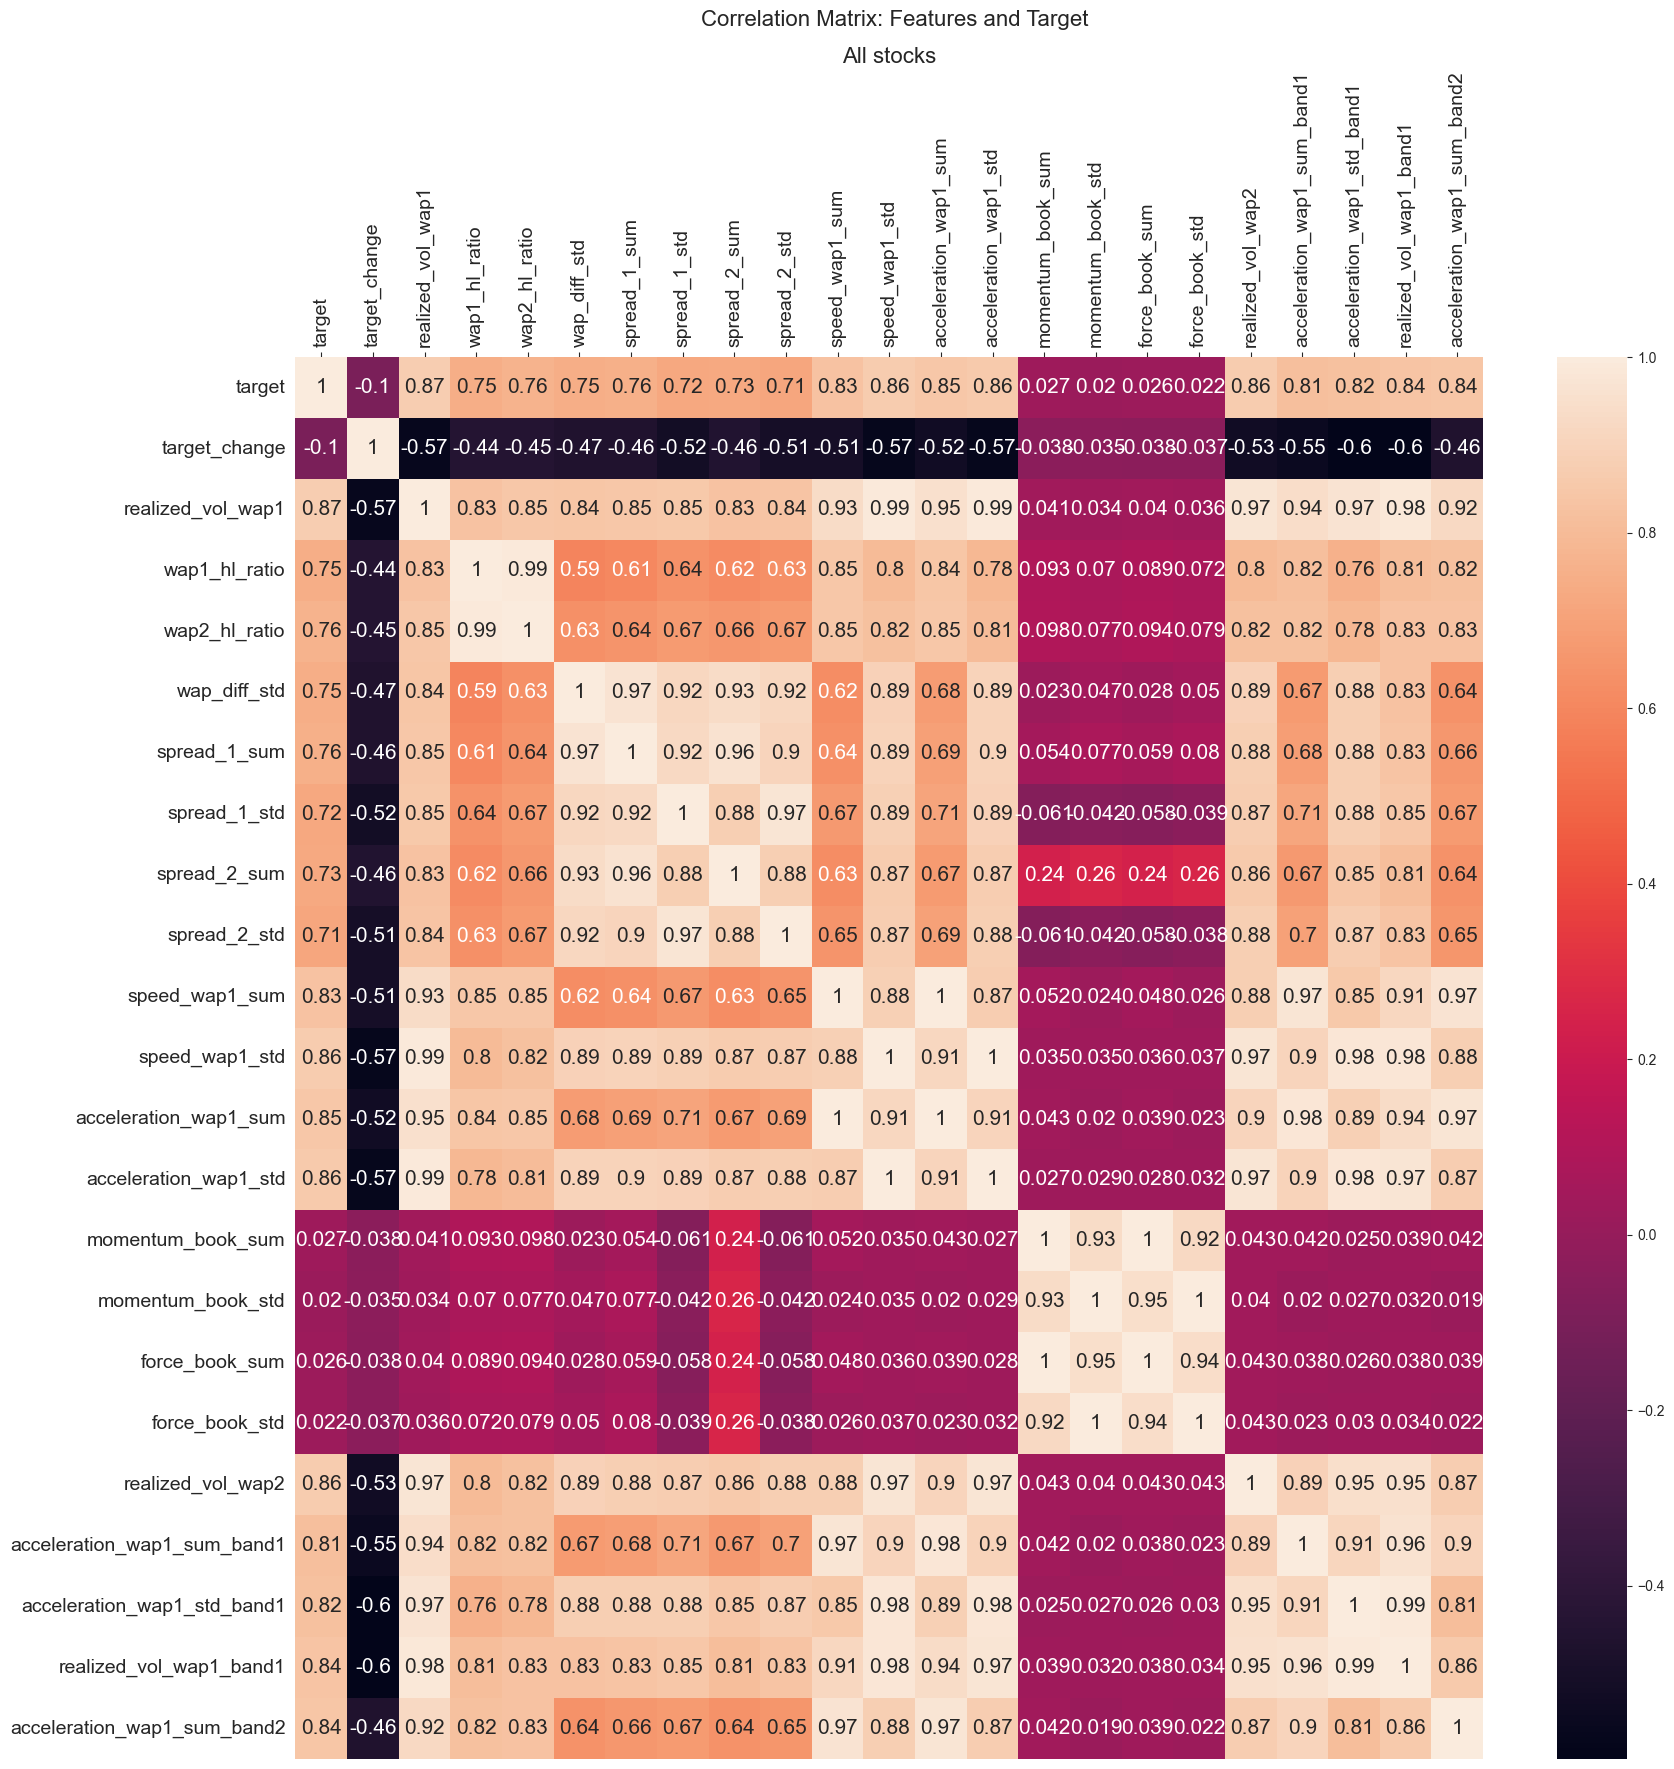

In [97]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_1.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("All stocks", fontsize=16)
plt.tight_layout()
plt.show()


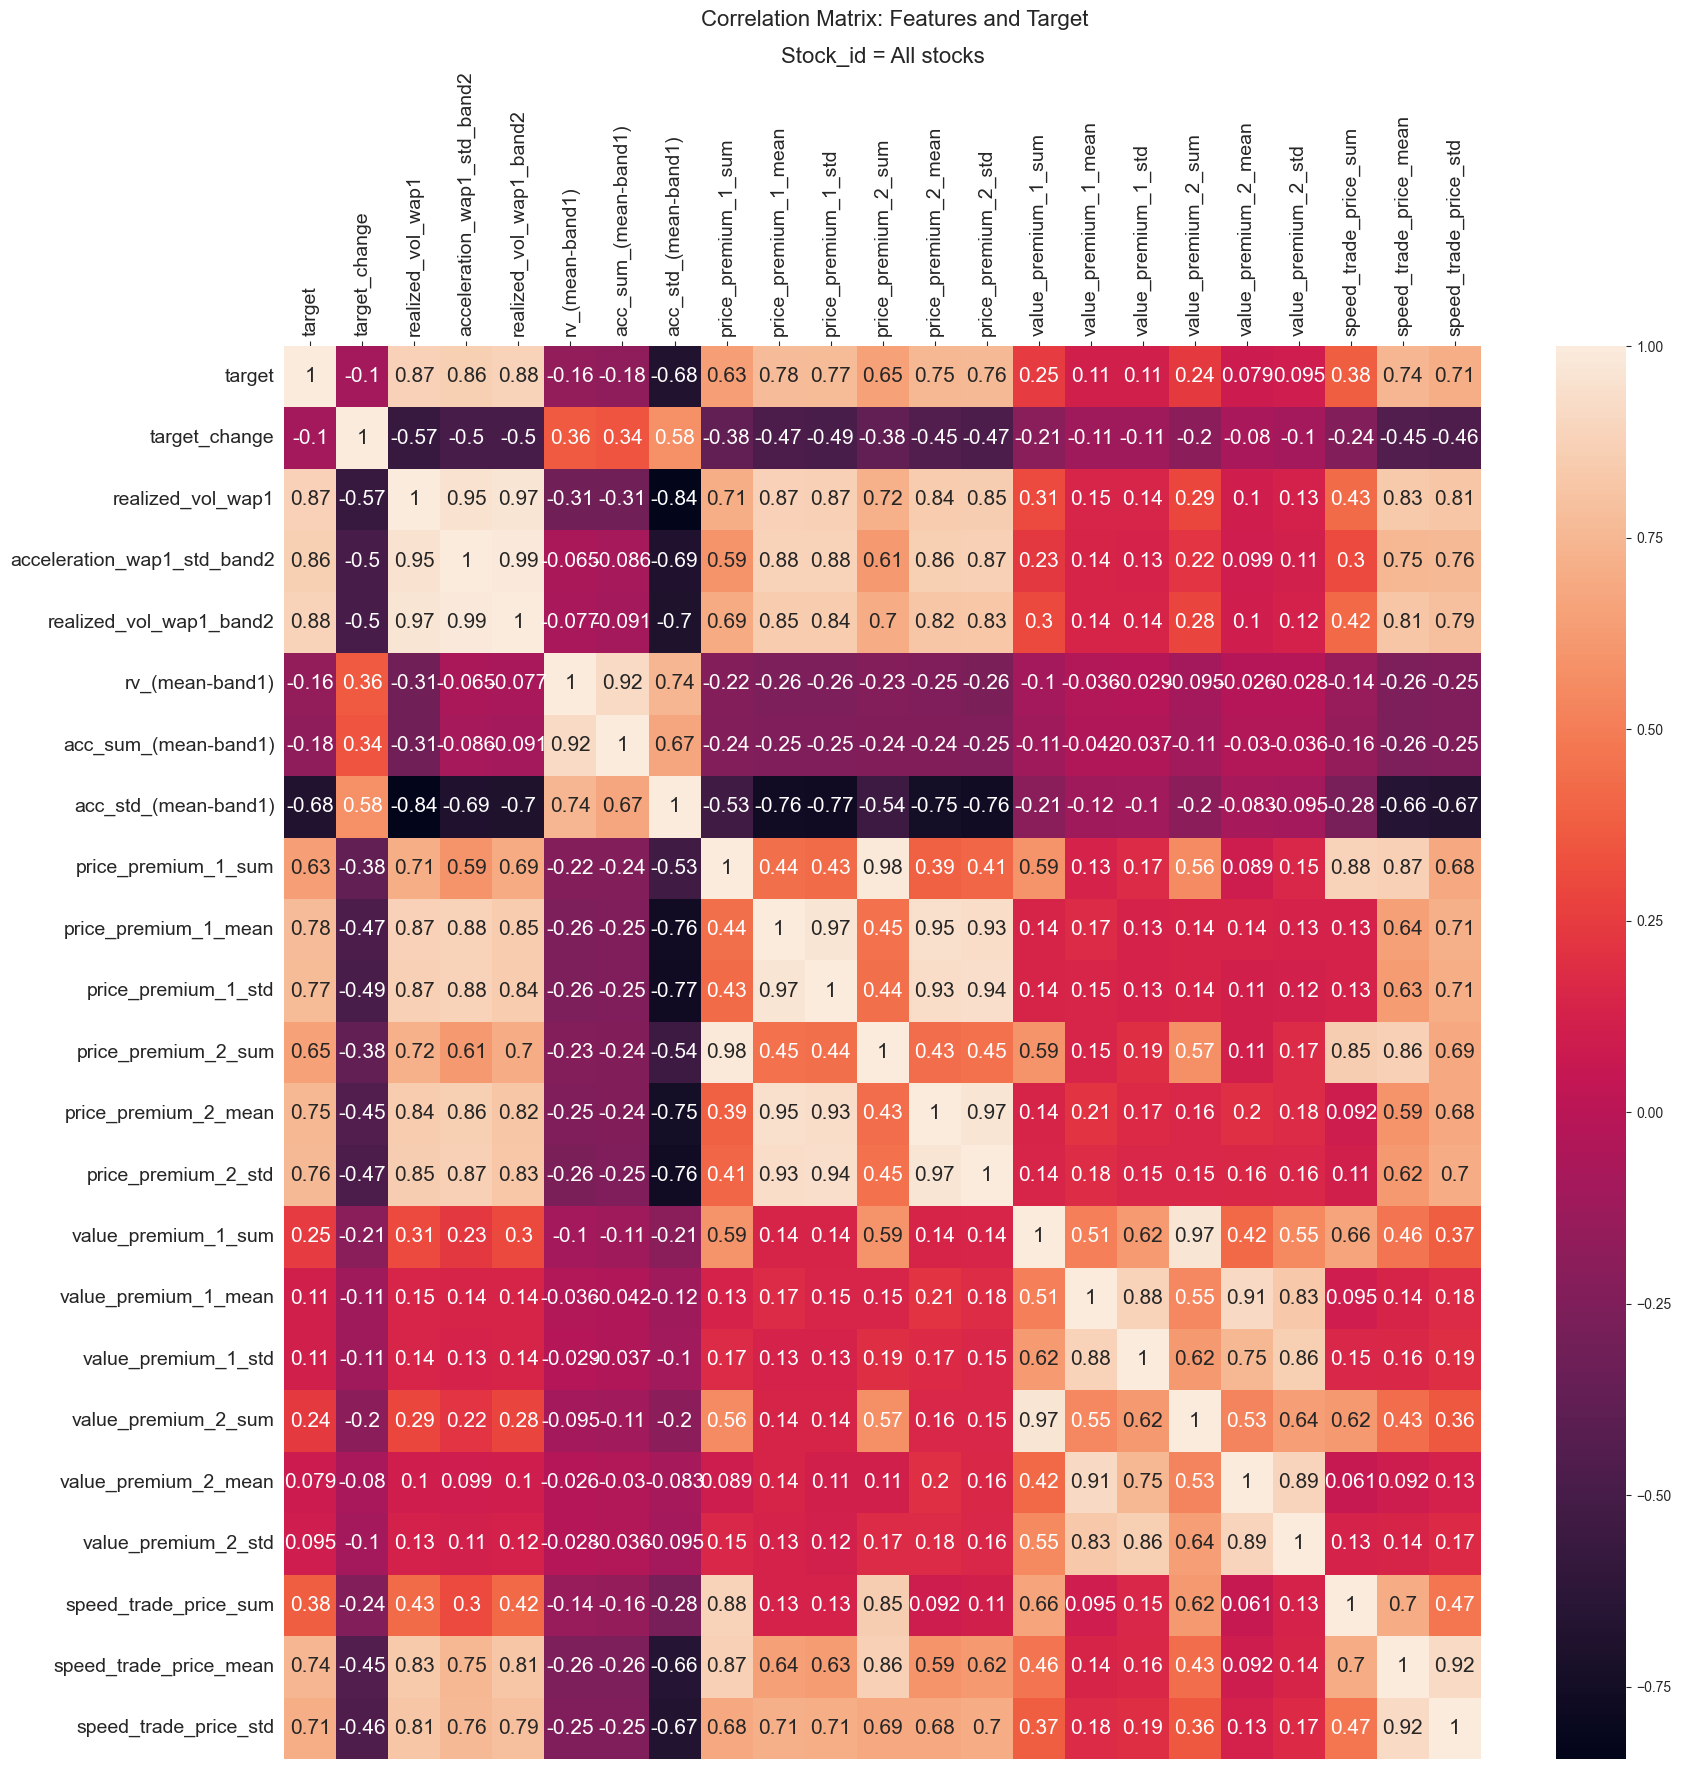

In [98]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_2.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

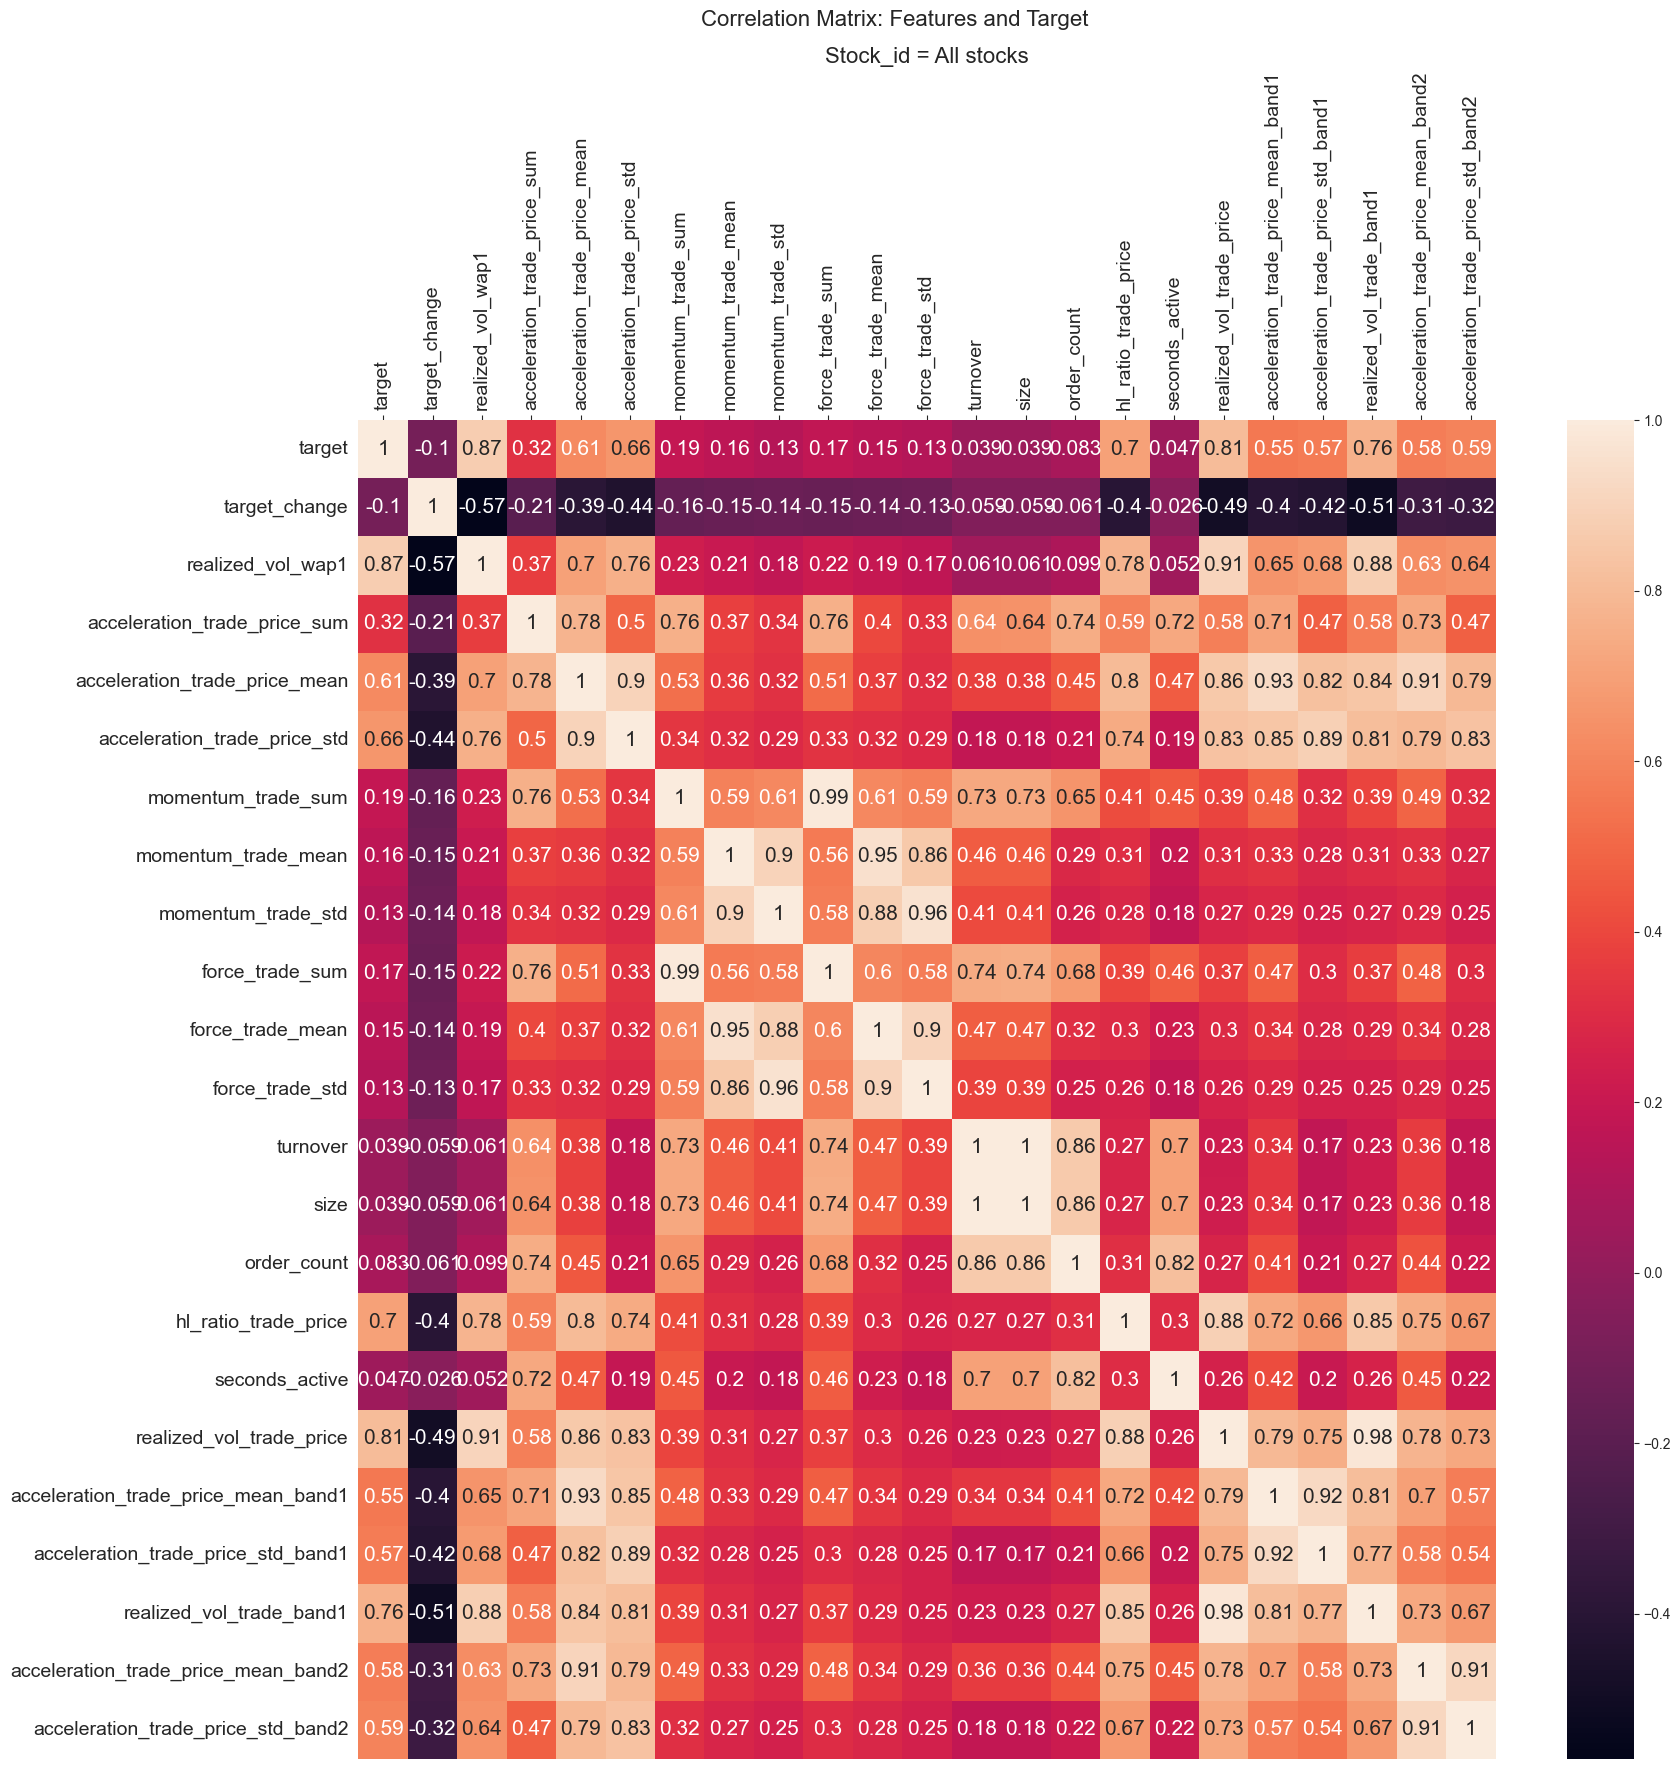

In [99]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_3.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

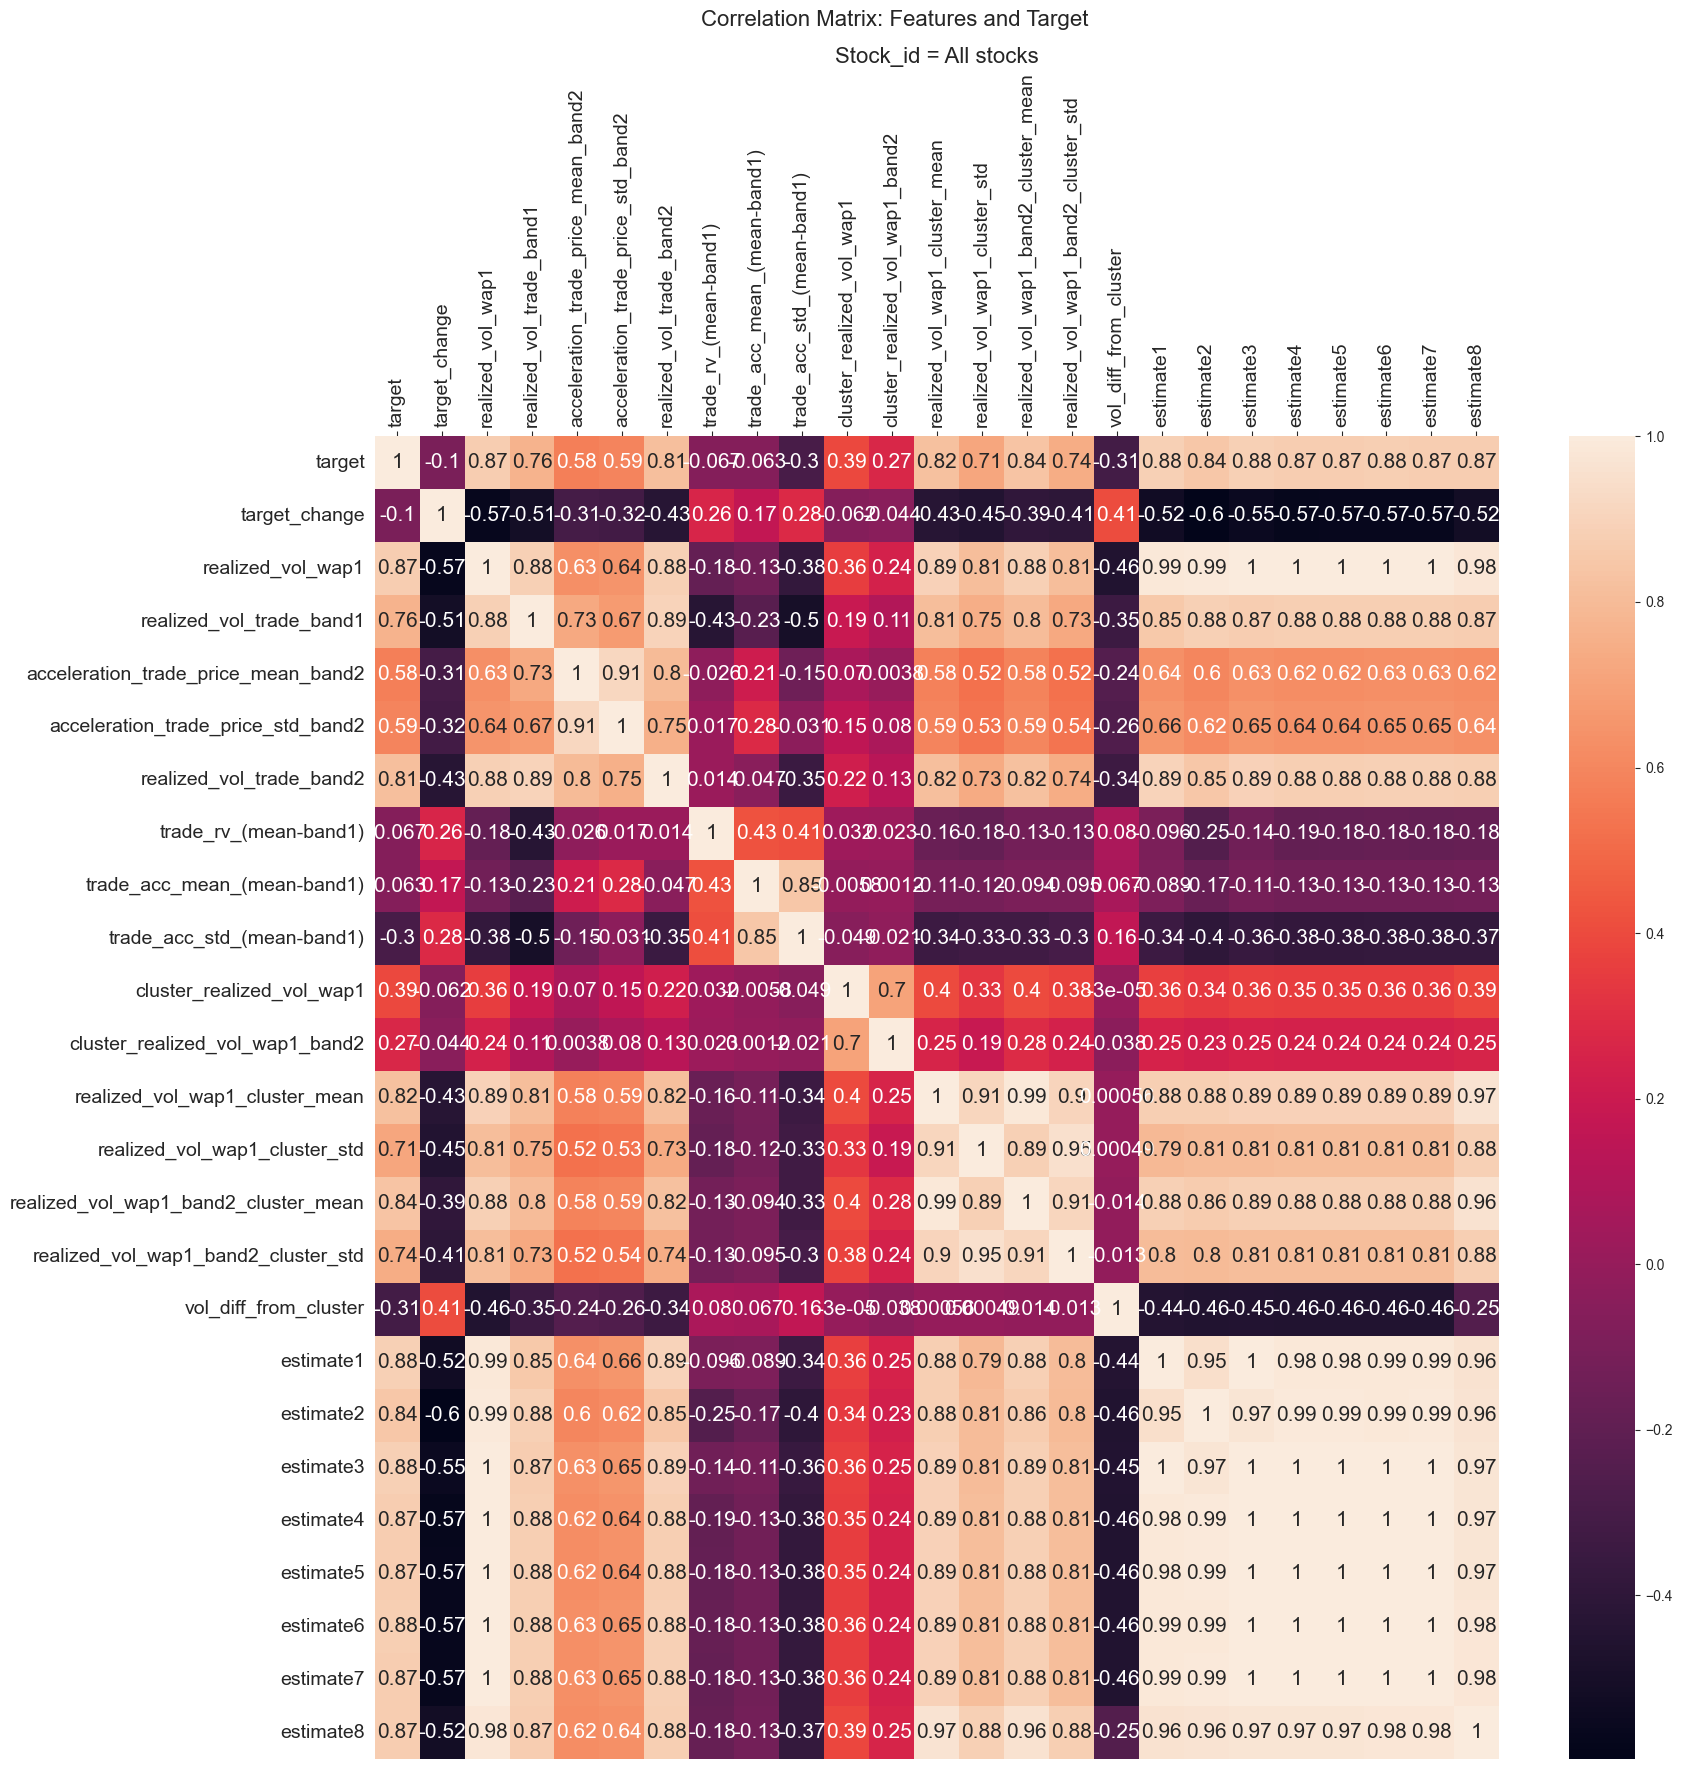

In [251]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_4.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

**Key Observation from Correlation heatmaps**

1. **target**: The top features that have significant correlations (based on the Pearson Correlation Coefficient) with the target are:

    * **realized_vol_wap1_band2** : 0.88
    * **realized_vol_wap1**: 0.87
    * **realized_vol_wap2** : 0.86
    * **speed_wap1_std**: 0.86
    * **acceleration_wap1_std**: 0.86
    * **realized_vol_wap1_band2_cluster_mean**: 0.84

2. **target_change**: target_change is negatively correlated to the features that have high correlation to target.

    * **acceleration_wap1_std_band1**: -0.6
    * **acceleration_wap1_std**: -0.58
    * **realized_vol_wap1**: - 0.57
    
     This tells us that as the realized volatility of current 10-minute time period goes higher, the realized volatility of the next 10-minutes i.e. the 'target' is expected to reduce in most cases.

2. **target_change**: target_change is positively correlated to the following features:

    * **acc_std_(mean-band1)**: 0.58 
    * **rv_(mean-band1)**: 0.36

    The correlation of 0.58 with 'acceleration_std_(mean-band1) suggests that if the acceleration standard deviation in band1(first 5 minutes of the current 10-min period) is lower than 50% of the acceleration standard deviation during the full 10-minute period, then target is expected to be higher than realized volatility of the current 10-minute period.
    

### 2.6 Pre-processing the test dataset

Here we preprocess the test dataset. The only difference is that we provide the pre-processor here, the cluster labels generated during the pre-processing of the training dataset.


In [13]:
cluster_labels = pd.read_csv("../WIP_data/preprocess/clusters_train_set.csv")
cluster_labels.head()

,stock_id,cluster_realized_vol_wap1,cluster_realized_vol_wap1_band2
0,0,1,2
1,1,1,2
2,2,0,0
3,3,2,1
4,4,1,2


In [23]:
book_path = '../WIP_data/book/test'
trade_path = '../WIP_data/trade/test'
target_file = '../Raw_data/train.csv'
preprocess_path = '../WIP_data/preprocess'
features_for_clustering = ['realized_vol_wap1', 'realized_vol_wap1_band2']
no_of_clusters = 3


start_time = time.time()

pp2 = PreProcess()


all_features_test =  pp2.generate_features(book_path, trade_path, target_file, features_for_clustering, \
                    n_clusters = no_of_clusters, cluster_labels = cluster_labels, data_type = 'test', create_clusters = False, time_splits=2)

end_time = time.time()

print(f'Time taken for feature creation on test set of all 112 stocks = {end_time-start_time}')

save_file(all_features_test, "all_features_all_stocks_test_set.csv", preprocess_path)


Time taken for feature creation on test set of all 112 stocks = 1151.6453311443329
Writing file.  "../WIP_data/preprocess\all_features_all_stocks_test_set.csv"


## 3.0 Modeling

In [5]:
all_features = pd.read_csv('../WIP_data/preprocess/all_features_all_stocks_with_estimators.csv')
all_features.head()

,stock_id,time_id,wap1_hl_ratio,wap2_hl_ratio,wap_diff_std,spread_1_sum,spread_1_std,spread_2_sum,spread_2_std,speed_wap1_sum,...,acc_sum_(mean-band2,acc_std_(mean-band2,estimate1,estimate2,estimate3,estimate4,estimate5,estimate6,estimate7,estimate8
0,0,5.0,1.003481,1.003729,0.000486,0.519205,0.000212,0.707578,0.000224,0.046769,...,0.003519,-0.000055,0.004271,0.004727,0.004385,0.004505,0.004502,0.004411,0.004455,0.005109
1,0,11.0,1.001135,1.001492,0.000249,0.259476,0.000185,0.421187,0.000218,0.007391,...,-0.001131,-0.000033,0.001334,0.001075,0.001269,0.001211,0.001208,0.001200,0.001202,0.001896
2,0,16.0,1.003665,1.003992,0.000447,0.440097,0.000159,0.710535,0.000307,0.016550,...,0.004677,-0.000014,0.001989,0.002748,0.002179,0.002399,0.002384,0.002308,0.002338,0.002497
3,0,31.0,1.002972,1.002692,0.000432,0.538534,0.000252,0.691711,0.000327,0.011988,...,0.002689,-0.000035,0.002530,0.002618,0.002552,0.002574,0.002574,0.002521,0.002547,0.002862
4,0,62.0,1.000928,1.001148,0.000316,0.240861,0.000122,0.420857,0.000180,0.011892,...,-0.002466,-0.000051,0.002075,0.001714,0.001985,0.001903,0.001899,0.001884,0.001889,0.002217


### 3.1 Training a Neural Network Model - with numeric features only

In [258]:
all_features = all_features.drop(columns=['target_change'])

In [259]:
all_features = all_features.dropna(how='any')

y = all_features['target'].to_numpy()

X = all_features.drop(columns = ['stock_id','time_id','target', 'row_id', \
                                 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_band2'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

with open('../WIP_data/preprocess/nn_feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


In [260]:
X.shape

(341428, 81)

In [261]:
model2 = Sequential()
model2.add(Dense(100,activation=LeakyReLU(alpha=0.5), input_shape=(81,)))
model2.add(Dense(100,activation=LeakyReLU(alpha=0.3)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss = keras_rmspe)

model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 100)               8200      
                                                                 
 dense_100 (Dense)           (None, 100)               10100     
                                                                 
 dense_101 (Dense)           (None, 1)                 101       
                                                                 
Total params: 18,401
Trainable params: 18,401
Non-trainable params: 0
_________________________________________________________________


In [262]:
early_stopping_monitor = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=8, min_lr=0.000001)
save_best = ModelCheckpoint('../WIP_data/preprocess/best_nn_model_only_numerical_100x2_lrelu.hdf5', \
                            save_best_only=True, save_weight_only=True)

history2 = model2.fit(X, y, validation_split = 0.2, epochs= 300, batch_size = 128, callbacks=[early_stopping_monitor, reduce_lr, save_best])


Epoch 1/300
2134/2134 [==============================] - 16s 6ms/step - loss: 22.2695 - val_loss: 6.1113 - lr: 0.0010
Epoch 2/300
2134/2134 [==============================] - 12s 6ms/step - loss: 5.4305 - val_loss: 1.8841 - lr: 0.0010
Epoch 3/300
2134/2134 [==============================] - 13s 6ms/step - loss: 1.9411 - val_loss: 0.2898 - lr: 0.0010
Epoch 4/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.9770 - val_loss: 0.3823 - lr: 0.0010
Epoch 5/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.6737 - val_loss: 0.2661 - lr: 0.0010
Epoch 6/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.4513 - val_loss: 0.2529 - lr: 0.0010
Epoch 7/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.5266 - val_loss: 0.2773 - lr: 0.0010
Epoch 8/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.3746 - val_loss: 0.6688 - lr: 0.0010
Epoch 9/300
2134/2134 [==============================] - 12s 6m

Epoch 69/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2262 - val_loss: 0.2157 - lr: 6.2500e-05
Epoch 70/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2256 - val_loss: 0.2273 - lr: 6.2500e-05
Epoch 71/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2263 - val_loss: 0.2182 - lr: 6.2500e-05
Epoch 72/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2258 - val_loss: 0.2154 - lr: 6.2500e-05
Epoch 73/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2252 - val_loss: 0.2173 - lr: 6.2500e-05
Epoch 74/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2258 - val_loss: 0.2151 - lr: 6.2500e-05
Epoch 75/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2256 - val_loss: 0.2148 - lr: 6.2500e-05
Epoch 76/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2255 - val_loss: 0.2174 - lr: 6.2500e-05
Epoch 77/300
2134/2134 [

Epoch 136/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2191 - val_loss: 0.2132 - lr: 1.0000e-06
Epoch 137/300
2134/2134 [==============================] - 14s 6ms/step - loss: 0.2191 - val_loss: 0.2133 - lr: 1.0000e-06
Epoch 138/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2191 - val_loss: 0.2133 - lr: 1.0000e-06
Epoch 139/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2190 - val_loss: 0.2133 - lr: 1.0000e-06
Epoch 140/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2190 - val_loss: 0.2133 - lr: 1.0000e-06
Epoch 141/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2190 - val_loss: 0.2133 - lr: 1.0000e-06
Epoch 142/300
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2190 - val_loss: 0.2134 - lr: 1.0000e-06
Epoch 143/300
2134/2134 [==============================] - 13s 6ms/step - loss: 0.2190 - val_loss: 0.2132 - lr: 1.0000e-06
Epoch 144/300
21

In [264]:
model2.save_weights("../WIP_data/preprocess/nn_model_only_numerical_100x2_lrelu_final_weights.hdf5")

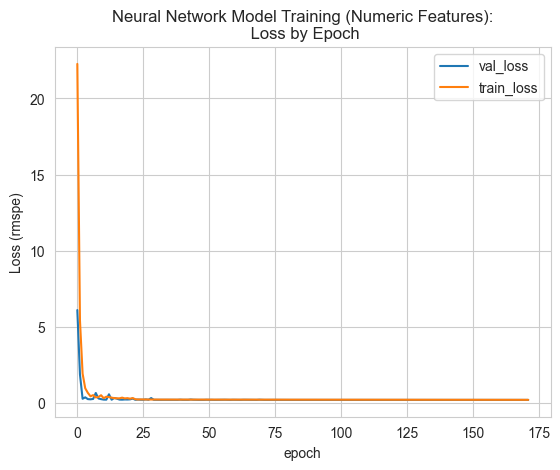

In [263]:
plt.plot(history2.history['val_loss'], label='val_loss')
plt.plot(history2.history['loss'], label='train_loss')
plt.xlabel('epoch')
plt.ylabel('Loss (rmspe)')
plt.title('Neural Network Model Training (Numeric Features):\n Loss by Epoch')
plt.legend()
plt.show()

### 3.2 Neural Network Model - numeric & categorical features

In [273]:

#clusters as categorical feature


X_clusters = all_features[['cluster_realized_vol_wap1','cluster_realized_vol_wap1_band2']]


In [272]:



#model architecture - build an embedding layer for clusters

def emb_sz_rule(n_cat):
    return min(600, round(1.6* n_cat**0.56))

numeric_inputs = Input((81,), name="numeric_inputs")
cluster_inputs = Input((2,), name="cluster_inputs")

embedding_layer1 = Embedding(4, emb_sz_rule(4), input_length=2, name='Embedding_layer_clusters')

cluster_inputs_transformed = embedding_layer1(cluster_inputs)
cluster_inputs_transformed = Flatten()(cluster_inputs_transformed)

inp = Concatenate()([cluster_inputs_transformed, numeric_inputs])
inp = Dense(100, activation=LeakyReLU(alpha=0.5))(inp)
inp = Dense(100, activation=LeakyReLU(alpha=0.3))(inp)
out = Dense(1, name='output')(inp)

model5 = Model(inputs = [cluster_inputs, numeric_inputs], outputs=out, name="model_with_clusters_")

model5.compile(optimizer='adam', loss = keras_rmspe)

model5.summary()


Model: "model_with_clusters_"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cluster_inputs (InputLayer)    [(None, 2)]          0           []                               
                                                                                                  
 Embedding_layer_clusters (Embe  (None, 2, 3)        12          ['cluster_inputs[0][0]']         
 dding)                                                                                           
                                                                                                  
 flatten_16 (Flatten)           (None, 6)            0           ['Embedding_layer_clusters[0][0]'
                                                                 ]                                
                                                                               

In [274]:
early_stopping_monitor = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=8, min_lr=0.000001)
save_best = ModelCheckpoint('../WIP_data/preprocess/best_nn_model_num_and_2cat_100x2_lrelu.hdf5', save_best_only=True, save_weight_only=True)

history5 = model5.fit([X_clusters, X], y, validation_split = 0.2, epochs= 200, batch_size=128, callbacks=[early_stopping_monitor, reduce_lr, save_best])


Epoch 1/200
2134/2134 [==============================] - 17s 7ms/step - loss: 18.4031 - val_loss: 4.0048 - lr: 0.0010
Epoch 2/200
2134/2134 [==============================] - 14s 7ms/step - loss: 5.1366 - val_loss: 0.8915 - lr: 0.0010
Epoch 3/200
2134/2134 [==============================] - 14s 6ms/step - loss: 1.9854 - val_loss: 0.6836 - lr: 0.0010
Epoch 4/200
2134/2134 [==============================] - 15s 7ms/step - loss: 1.1031 - val_loss: 0.2452 - lr: 0.0010
Epoch 5/200
2134/2134 [==============================] - 14s 7ms/step - loss: 0.8538 - val_loss: 0.2835 - lr: 0.0010
Epoch 6/200
2134/2134 [==============================] - 14s 7ms/step - loss: 0.4937 - val_loss: 0.2520 - lr: 0.0010
Epoch 7/200
2134/2134 [==============================] - 14s 7ms/step - loss: 0.4885 - val_loss: 0.2787 - lr: 0.0010
Epoch 8/200
2134/2134 [==============================] - 15s 7ms/step - loss: 0.4155 - val_loss: 0.2379 - lr: 0.0010
Epoch 9/200
2134/2134 [==============================] - 14s 7m

2134/2134 [==============================] - 10s 5ms/step - loss: 0.2254 - val_loss: 0.2167 - lr: 6.2500e-05
Epoch 70/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2257 - val_loss: 0.2154 - lr: 6.2500e-05
Epoch 71/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2251 - val_loss: 0.2153 - lr: 6.2500e-05
Epoch 72/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2254 - val_loss: 0.2147 - lr: 6.2500e-05
Epoch 73/200
2134/2134 [==============================] - 9s 4ms/step - loss: 0.2251 - val_loss: 0.2154 - lr: 6.2500e-05
Epoch 74/200
2134/2134 [==============================] - 9s 4ms/step - loss: 0.2250 - val_loss: 0.2151 - lr: 6.2500e-05
Epoch 75/200
2134/2134 [==============================] - 8s 4ms/step - loss: 0.2254 - val_loss: 0.2187 - lr: 6.2500e-05
Epoch 76/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2248 - val_loss: 0.2147 - lr: 6.2500e-05
Epoch 77/200
2134/2134 [================

2134/2134 [==============================] - 12s 5ms/step - loss: 0.2184 - val_loss: 0.2128 - lr: 1.0000e-06
Epoch 137/200
2134/2134 [==============================] - 11s 5ms/step - loss: 0.2184 - val_loss: 0.2126 - lr: 1.0000e-06
Epoch 138/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2184 - val_loss: 0.2127 - lr: 1.0000e-06
Epoch 139/200
2134/2134 [==============================] - 10s 5ms/step - loss: 0.2184 - val_loss: 0.2127 - lr: 1.0000e-06
Epoch 140/200
2134/2134 [==============================] - 11s 5ms/step - loss: 0.2183 - val_loss: 0.2126 - lr: 1.0000e-06
Epoch 141/200
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2183 - val_loss: 0.2129 - lr: 1.0000e-06
Epoch 142/200
2134/2134 [==============================] - 11s 5ms/step - loss: 0.2183 - val_loss: 0.2127 - lr: 1.0000e-06
Epoch 143/200
2134/2134 [==============================] - 12s 6ms/step - loss: 0.2183 - val_loss: 0.2128 - lr: 1.0000e-06
Epoch 144/200
2134/2134 [=====

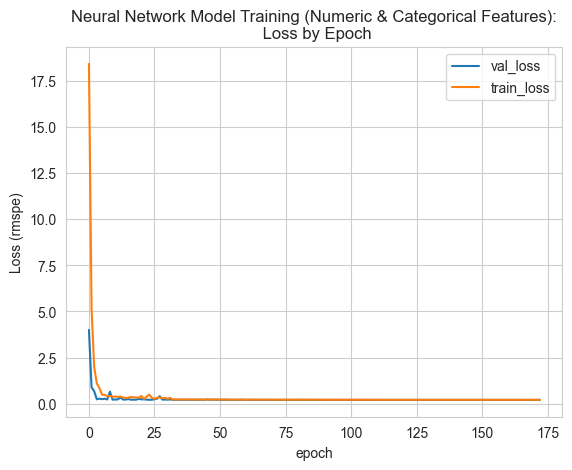

In [276]:
plt.plot(history5.history['val_loss'], label='val_loss')
plt.plot(history5.history['loss'], label='train_loss')
plt.xlabel('epoch')
plt.ylabel('Loss (rmspe)')
plt.title('Neural Network Model Training (Numeric & Categorical Features):\n Loss by Epoch')
plt.legend()
plt.show()

In [275]:
model5.save_weights("../WIP_data/preprocess/nn_model_num_and_2cat_final_weights.hdf5")


### 3.3 Light GBM Model

In [44]:
all_features = all_features.dropna(how='any')
X_lgb = all_features.drop(columns=['time_id', 'target', 'row_id', 'target_change'])
y_lgb = all_features['target']
X_lgb.shape, y_lgb.shape

((341428, 81), (341428,))

In [49]:
## Model based on LightGBM

seed = 123
np.random.seed(seed)

def lgb_rmspe(preds, eval_data):
    #custom evaluation function for lgb model
    y_true = eval_data.get_label()
    
    return 'rmspe', rmspe(y_true, preds), False

params = {'learning_rate': 0.01,  'lambda_l1': 6.3, 'num_leaves': 800, 'min_sum_hessian_in_leaf': 18.2,
        'feature_fraction': 0.6, 'feature_fraction_bynode': 0.7, 'bagging_fraction': 0.9, 'bagging_freq': 40,
        'min_data_in_leaf': 900, 'max_depth': 5, 'seed': seed, 'feature_fraction_seed': seed,
        'bagging_seed': seed, 'drop_seed': seed, 'data_random_seed': seed, 'objective': 'rmse',
        'boosting': 'gbdt', 'verbosity': -1, 'n_jobs': -1}   

X_train, X_test, y_train, y_test = train_test_split(X_lgb, y_lgb, test_size=0.2, random_state = seed)
cat_features = ['stock_id', 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_band2']

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

model = lgb.train(params = params, train_set = lgb_train, valid_sets = [lgb_train, lgb_test], num_boost_round = 5000, \
                  early_stopping_rounds = 200, verbose_eval = 200, feval = lgb_rmspe)


    

Training until validation scores don't improve for 200 rounds
[200]	training's l2: 2.23324e-06	training's rmspe: 0.436322	valid_1's l2: 2.26251e-06	valid_1's rmspe: 0.451093
[400]	training's l2: 1.86828e-06	training's rmspe: 0.341786	valid_1's l2: 1.89304e-06	valid_1's rmspe: 0.359572
[600]	training's l2: 1.80088e-06	training's rmspe: 0.32044	valid_1's l2: 1.82408e-06	valid_1's rmspe: 0.339281
[800]	training's l2: 1.77967e-06	training's rmspe: 0.313893	valid_1's l2: 1.80283e-06	valid_1's rmspe: 0.333259
[1000]	training's l2: 1.77329e-06	training's rmspe: 0.312086	valid_1's l2: 1.7965e-06	valid_1's rmspe: 0.331563
[1200]	training's l2: 1.76898e-06	training's rmspe: 0.310761	valid_1's l2: 1.79205e-06	valid_1's rmspe: 0.330304
[1400]	training's l2: 1.7676e-06	training's rmspe: 0.310594	valid_1's l2: 1.79056e-06	valid_1's rmspe: 0.330184
Early stopping, best iteration is:
[1238]	training's l2: 1.76794e-06	training's rmspe: 0.310442	valid_1's l2: 1.79093e-06	valid_1's rmspe: 0.33001


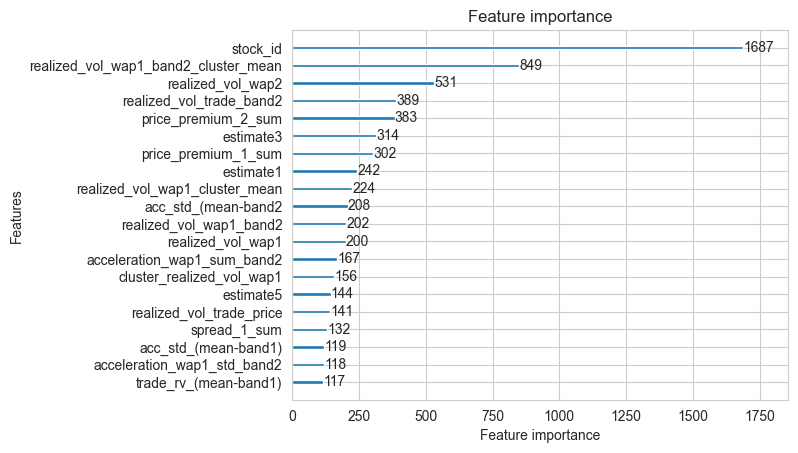

In [50]:
lgb.plot_importance(model, max_num_features=20)
plt.show()

### 3.4 Making Predictions on test set using best model

During model buiilding and training, the neural network model based on numerical and categorical (stock clusters) features performed the best. 

Let's evaluate the performance on the neural network models on the test set.


In [237]:
all_features_test = pd.read_csv('../WIP_data/preprocess/all_features_all_stocks_test_set.csv')
all_features_test.head()

,stock_id,time_id,wap1_hl_ratio,wap2_hl_ratio,wap_diff_std,spread_1_sum,spread_1_std,spread_2_sum,spread_2_std,speed_wap1_sum,...,realized_vol_wap1_band2_cluster_std,vol_diff_from_cluster,estimate1,estimate2,estimate3,estimate4,estimate5,estimate6,estimate7,estimate8
0,0,147,1.002478,1.002843,0.000380,0.334905,0.000235,0.519309,0.000272,0.023628,...,0.000520,0.000209,0.003084,0.002589,0.002961,0.002847,0.002842,0.002821,0.002829,0.002941
1,0,159,1.005497,1.005658,0.000321,0.362485,0.000175,0.554565,0.000279,0.029929,...,0.000532,-0.000297,0.003570,0.002738,0.003362,0.003181,0.003168,0.003141,0.003147,0.003005
2,0,227,1.003511,1.003844,0.000492,0.603636,0.000207,0.827643,0.000282,0.050178,...,0.000979,-0.000044,0.004734,0.006384,0.005147,0.005620,0.005590,0.005430,0.005495,0.005538
3,0,254,1.010356,1.010221,0.001331,1.797783,0.001001,2.177967,0.001011,0.072568,...,0.003020,0.002617,0.011428,0.008697,0.010745,0.010154,0.010108,0.010033,0.010047,0.011371
4,0,310,1.007194,1.009292,0.001311,1.910520,0.000789,2.459195,0.001009,0.088999,...,0.002480,0.002939,0.010097,0.010414,0.010176,0.010257,0.010256,0.010114,0.010185,0.011725


In [265]:
with open('../WIP_data/preprocess/nn_feature_scaler.pkl', 'rb') as file:
    scaler_test = pickle.load(file)

all_features_test = all_features_test.dropna(how='any')

y_test = all_features_test['target'].to_numpy()

X_test = all_features_test.drop(columns = ['stock_id','time_id','target', 'row_id', 
                                           'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_band2'])
X_test = scaler_test.transform(X_test)

X_test.shape


(85385, 81)

In [266]:
X_test_cluster = all_features_test[['cluster_realized_vol_wap1','cluster_realized_vol_wap1_band2']]

X_test_cluster.shape


(85385, 2)

In [271]:
print("Evaluation: Neural network model based on numerical features\n")

model_replica = get_model_lrelu(X_test.shape[1], neurons=[100,100], alphas=[0.5,0.3])
model_replica.load_weights('../WIP_data/preprocess/best_nn_model_only_numerical_100x2_lrelu.hdf5')

model_replica.compile(optimizer = 'adam', loss = keras_rmspe)

results = model_replica.evaluate(X_test, y_test)

print("\nRMSPE loss on test set: ", results)

Evaluation: Neural network model based on numerical features

2669/2669 [==============================] - 4s 1ms/step - loss: 0.2187

RMSPE loss on test set:  0.2187367081642151


In [280]:
print("Evaluation: Neural network model based on numerical and categorical features\n")

model_replica2 = Model(inputs = [cluster_inputs, numeric_inputs], outputs=out, name="model_replica_with_clusters_")
model_replica2.load_weights('../WIP_data/preprocess/best_nn_model_num_and_2cat_100x2_lrelu.hdf5')

model_replica2.compile(optimizer = 'adam', loss = keras_rmspe)

results2 = model_replica2.evaluate([X_test_cluster, X_test] , y_test)

print("\nRMSPE loss on test set: ", results2)

Evaluation: Neural network model based on numerical and categorical features

2669/2669 [==============================] - 4s 1ms/step - loss: 0.2182

RMSPE loss on test set:  0.21816956996917725


# Conclusions

* The training dataset was preprocessed to generate features from book and trade data. In addition, cluster features and some estimator features were generated.
* 3 different models were trained :
        * Neural network model based on numeric features only
        * Neural network model based on numeric and catgorical features(stock clusters) only
        * Light GBM model
        
* The neural network model based on mumeric and catgorical features performed the best, with rmspe loss on validation set of **0.2126**.

* This model was used to predict target for the test set. The rmspe loss on test set was **0.21817**. 
